In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v2.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

head(MM_cell_line)
head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Sample,GENE_NAME,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,⋯,RPMI8226_ATCC_p7,SKMM1_p6,SKMM2_DSMZ_p17,U266_ATCC_p8,UTMC2_p6,VP6_DJ_p5,XG1_p5,XG2_p5,XG6_p5,XG7_p6
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,2,0,100,2,0,0,2,88,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,TNMD,1,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,DPM1,3949,4134,4795,8278,2262,2587,3607,2450,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,SCYL3,1597,1513,2412,1988,1530,926,1415,573,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,C1orf112,3072,1488,2193,4091,3208,1170,3614,1618,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,FGR,0,22,701,5,2,4,89,4,⋯,0,125,777,50,1890,2315,1514,5,3776,847


GENE_ID,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,⋯,46,14,303,2007,58,77,1037,11,174,22


[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)

# checking output head to confirm removal

head(MM_cell_line)
head(MM_patients)
head(MM_combined)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,RPMI8226_ATCC_p7,SKMM1_p6,SKMM2_DSMZ_p17,U266_ATCC_p8,UTMC2_p6,VP6_DJ_p5,XG1_p5,XG2_p5,XG6_p5,XG7_p6
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,0,125,777,50,1890,2315,1514,5,3776,847


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2341_1_BM,MMRF_2501_1_BM,MMRF_1383_1_BM,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,12,16,43,594,693,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,2013,1745,2403,1847,973,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,231,809,203,1208,425,710,922,1203,1160,587,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,87,319,31,183,85,174,292,478,218,107,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,318,105,119,190,2064,12,351,555,37,21,⋯,3064,46,46,14,303,58,77,11,174,22


,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,3064,46,46,14,303,58,77,11,174,22


ensembl_ids,gene_names
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
ENSG00000000938,FGR


[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes


MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

# checking output head

head(keep)
head(MM_combined.filtered)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,3064,46,46,14,303,58,77,11,174,22
ENSG00000000971,11,207,24,21,18,8,685,12,28,2,⋯,2566,27,13,5,28,30,18,1680,56,10


In [4]:
g2k = rownames(MM_combined.filtered)
CCLE_cell_line = data.frame(fread("CCLE_RNAseq_genes_counts_20180929.gct"))
gid = CCLE_cell_line$Name
gid2 = substr(gid, 1, 15)
rownames(CCLE_cell_line) = gid2

CCLE_cell_line = CCLE_cell_line[-1]
CCLE_cell_line = CCLE_cell_line[-1]

CCLE_cell_line_meta = data.frame(fread("Cell_lines_annotations_20181226.txt"))
CCLE_cell_line_meta_2 = CCLE_cell_line_meta[(CCLE_cell_line_meta$type == 'multiple_myeloma'),]
head(CCLE_cell_line_meta_2)
length(CCLE_cell_line_meta_2)

,CCLE_ID,depMapID,Name,Pathology,Site_Primary,Site_Subtype1,Site_Subtype2,Site_Subtype3,Histology,Hist_Subtype1,⋯,Growth.Medium,Supplements,Freezing.Medium,Doubling.Time.from.Vendor,Doubling.Time.Calculated.hrs,type,type_refined,PATHOLOGIST_ANNOTATION,mutRate,tcga_code
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
8,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000829,HuNS1,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,,,,,NA,multiple_myeloma,multiple_myeloma,Lymphoma:Multiple_Myeloma,187.9139,MM
131,PCM6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-001162,PCM6,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,McCoy's 5A +20% FBS,NA,5%DMSO,,NA,multiple_myeloma,multiple_myeloma,Lymphoma:Multiple_Myeloma,NA,MM
171,KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000658,KMS-18,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,,,,,NA,multiple_myeloma,multiple_myeloma,NA,NA,MM
226,KMS21BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000598,KMS-21BM,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,RPMI 1640 medium with 10% fetal bovine serum.,NA,,NA,NA,multiple_myeloma,multiple_myeloma,Lymphoma:Multiple_Myeloma,160.2806,MM
227,KMS26_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000588,KMS-26,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,RPMI1640+10%FBS,NA,5%DMSO,,33.2,multiple_myeloma,multiple_myeloma,Lymphoma:Multiple_Myeloma,149.7017,MM
228,KMS27_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000576,KMS-27,primary,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,plasma_cell_myeloma,⋯,RPMI1640+10%FBS,NA,5%DMSO,,73.2,multiple_myeloma,multiple_myeloma,Lymphoma:Multiple_Myeloma,169.0553,MM


[1] 33

In [5]:
CCLE_bool2 = colnames(CCLE_cell_line) %in% CCLE_cell_line_meta_2$CCLE_ID
CCLE_cell_line_2 = CCLE_cell_line[,CCLE_bool2]
head(CCLE_cell_line_2)

,AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,⋯,L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,16,5,6,3,14,5,3,7,4,40,⋯,13,6,22,14,8,4,3,12,8,18
ENSG00000227232,877,916,809,1040,839,632,631,1466,1233,1105,⋯,2547,1633,1893,922,1269,955,1461,1088,1142,394
ENSG00000243485,5,1,6,1,11,4,4,2,4,2,⋯,3,0,3,3,9,4,2,4,2,4
ENSG00000237613,3,3,3,1,15,1,3,0,2,4,⋯,1,4,3,2,5,2,2,2,4,4
ENSG00000268020,1,2,3,0,5,1,0,0,1,0,⋯,2,1,1,2,1,1,2,1,0,3
ENSG00000240361,2,1,1,1,4,0,1,2,1,4,⋯,1,2,7,3,5,2,0,3,3,8


In [6]:
length(CCLE_cell_line_2[,1])

[1] 56202

In [7]:
CCLE_cell_line_3 = CCLE_cell_line_2[rownames(MM_combined.filtered),]

In [8]:
length(CCLE_cell_line_3[,1])

[1] 22459

In [10]:
length(MM_combined.filtered[,1])

[1] 22459

In [11]:
head(CCLE_cell_line_3)
head(MM_combined.filtered)

,AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,⋯,L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,56,642,15,17,204,13,4,7,14,24,⋯,16,30,22,26,27,26,14,29,16,31
ENSG00000000419,10884,7383,7458,5989,5646,9925,4271,5864,5662,7070,⋯,12073,9589,10297,7354,7369,42842,20907,5507,7197,3544
ENSG00000000457,2572,1482,2286,2691,1948,1876,2182,2068,2849,2044,⋯,4243,5365,3481,2653,3947,5933,3214,1439,1739,1797
ENSG00000000460,3844,2741,5379,3464,2487,2782,2757,2402,5753,4794,⋯,6044,1237,6129,1202,2375,4064,2694,2784,2183,2438
ENSG00000000938,3761,4,17,18,4547,13572,11348,42,2,9,⋯,62,5,20,397,29998,5497,3775,10,1288,369
ENSG00000000971,51,54,18,1617,36,62,11,155,27,12,⋯,18,47,44,31,1328,29,336,440,1044,41


,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,3064,46,46,14,303,58,77,11,174,22
ENSG00000000971,11,207,24,21,18,8,685,12,28,2,⋯,2566,27,13,5,28,30,18,1680,56,10


In [12]:
# normalizing combined data frame with vst

norm_combined = vst(as.matrix(MM_combined.filtered))

# checking output head

head(norm_combined)

,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


In [13]:
# separating out patient and cell line columns from norm_combined 

pat_bool = colnames(MM_combined.filtered) %in% colnames(MM_patients)
norm_pat = norm_combined[,pat_bool]
cell_bool = colnames(MM_combined.filtered) %in% colnames(MM_cell_line)
norm_cell = norm_combined[,cell_bool]

# checking output head

head(norm_pat)
head(norm_cell)

,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2341_1_BM,MMRF_2501_1_BM,MMRF_1383_1_BM,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,6.060798,9.545865,7.504912,5.678664,9.831334,5.882917,5.839145,6.162487,9.012450,10.080853,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,10.957643,11.180638,11.796341,10.495380,11.022594,11.404325,10.675590,10.560857,10.541196,10.548945,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,8.464263,9.266066,8.504619,10.465857,8.991437,9.954385,9.798282,9.614478,9.901645,9.854608,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,7.361361,8.102342,6.578214,8.019636,7.149116,8.146953,8.315703,8.425506,7.797638,7.725440,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,8.864747,6.942817,7.872284,8.063233,11.141904,5.882917,8.540640,8.609911,6.225164,6.277881,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,8.976686,9.666459,9.285435,7.717287,8.495919,6.037327,8.073008,6.039664,6.582150,6.067497,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


,ALMC1_DJ_p27,ALMC2_DJ_p11,AMO1_DSMZ_p8,ANBL6_DJ2_p13,COLO677_DSMZ_p8,Delta47_JCRB_p16,DP6_DJ_p7,EJM_DSMZ_p9,FLAM76_JCRB_p10,FR4_p6,⋯,RPMI8226_ATCC_p7,SKMM1_p6,SKMM2_DSMZ_p17,U266_ATCC_p8,UTMC2_p6,VP6_DJ_p5,XG1_p5,XG2_p5,XG6_p5,XG7_p6
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.183315,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,5.118442,6.661173
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.203237,10.090880,11.337907,10.916534,10.580120,11.126976,11.934854,11.032084,12.378849,12.643881
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.284631,9.782236,8.783722,10.035066,9.673136,9.484374,9.654509,8.863879,9.861965,9.674925
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,10.359418,10.360492,10.104075,10.378362,10.589037,9.883744,10.433379,10.133464,8.981951,8.534477
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,4.830701,7.279769,9.363245,6.271504,9.895878,10.190136,9.735164,5.239458,11.103832,8.793222
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,7.226316,5.705353,6.555933,5.130448,7.075538,5.971329,6.803862,8.441138,7.936526,7.174217


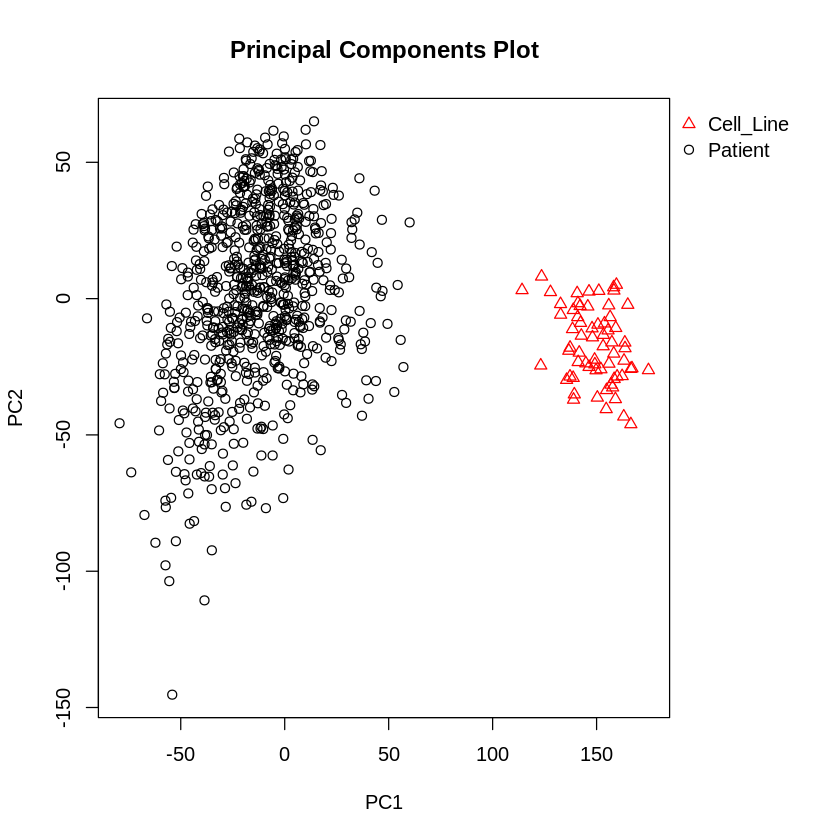

In [14]:
# using PCA to ensure populations are still distinct prior to analysis

symbols = c(rep(2, ncol(MM_cell_line)), rep(1, ncol(MM_patients)))
affycoretools::plotPCA(norm_combined, groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [15]:
# utilizing IQR to get vector of top 5000 and top 10000 genes

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

In [39]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)
    print(cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
      )
    
}

In [ ]:
 [1] MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 9 
 [2] MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 6
 [3] EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      = 17
 [4] KMS34_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 14
 [5] KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 29
 [6] NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  = 16
 [7] KMS20_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 33
 [8] JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 37
 [9] AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 25
[10] LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      = 48
[11] KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE= 32
[12] KMS27_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 36
[13] KMS28BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  = 45
[14] SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 31
[15] L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 34
[16] KMS21BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  = 50
[17] MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 56
[18] U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE   = 51
[19] KMS26_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 40
[20] KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 52
[21] OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 58
[22] KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = NA
[23] KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  = 44
[24] RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE = 49
[25] KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = 54 / 55
[26] HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    = NA
[27] KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     = 63

1 = molp2 6
2 = mm1s 9 
3 = kms34 14
4 = NCIh929 16
5 = EJM 17
6 = amo1 25
7 = kms18 29
8 = skmm2 31
9 = karpas620 32
10 = kms20 33
11 = l363 34
12 = kms27 36
13 = jjn3 37
14 = kms26 40
15 = kms12bm 44
16 = kms28bm 45
17 = lp1 48
18 = rpmi8226 49
19 = kms21bm 50
20 = u266 51
21 = khm1b 52
22 = kms11 54(sus) / 55(adh)
23 = molp8 56
24 = opm2 58
25 = kmm1 63
notfound = ke97 and huns1

In [42]:
num = c(9,6,17,14,29,16,33,37,25,48,32,36,45,31,34,50,56,51,40,52,58,00,44,49,54,63)
sort(num)

[1]  0  6  9 14 16 17 25 29 31 32 33 34 36 37 40 44 45 48 49 50 51 52 54 56 58
[26] 63

 [1] ANBL6_DJ2_p13       FLAM76_JCRB_p10     ALMC1_DJ_p27       
 [4] MM1R_ATCC_p7        JK6L_p5             MOLP2_DSMZ_p18     
 [7] ALMC2_DJ_p11        DP6_DJ_p7           MM1S_ATCC_p7       
[10] Karpas25_ECACC_p8   KP6_DJ_p8           INA6_p5            
[13] OH2_PLB_p8          KMS34_JCRB_p10      KAS61_DJ_p5        
[16] NCIH929_DSMZ_p8     EJM_DSMZ_p9         OCIMY7_p8          
[19] Karpas929_ECACC_p10 PCM6_Riken_p6       Karpas929_ECACC_p15
[22] OCIMY1_p6           Karpas417_ECACC_p12 XG6_p5             
[25] AMO1_DSMZ_p8        VP6_DJ_p5           JMW1_PLB_p6        
[28] XG1_p5              KMS18_p12           H1112_p5           
[31] SKMM2_DSMZ_p17      Karpas620_DSMZ_p14  KMS20_JCRB_p18     
[34] L363_DSMZ_p8        PE1_PLB_p10         KMS27_JCRB_p8      
[37] JJN3_DSMZ_p8        KMS12PE_JCRB_p9     PE2_PLB_p9         
[40] KMS26_JCRB_p9       OCIMY5_p10          XG2_p5             
[43] JIM3_ECACC_p10      KMS12BM_JCRB_p9     KMS28BM_JCRB_p9    
[46] KMS28PE_JCRB_p9     

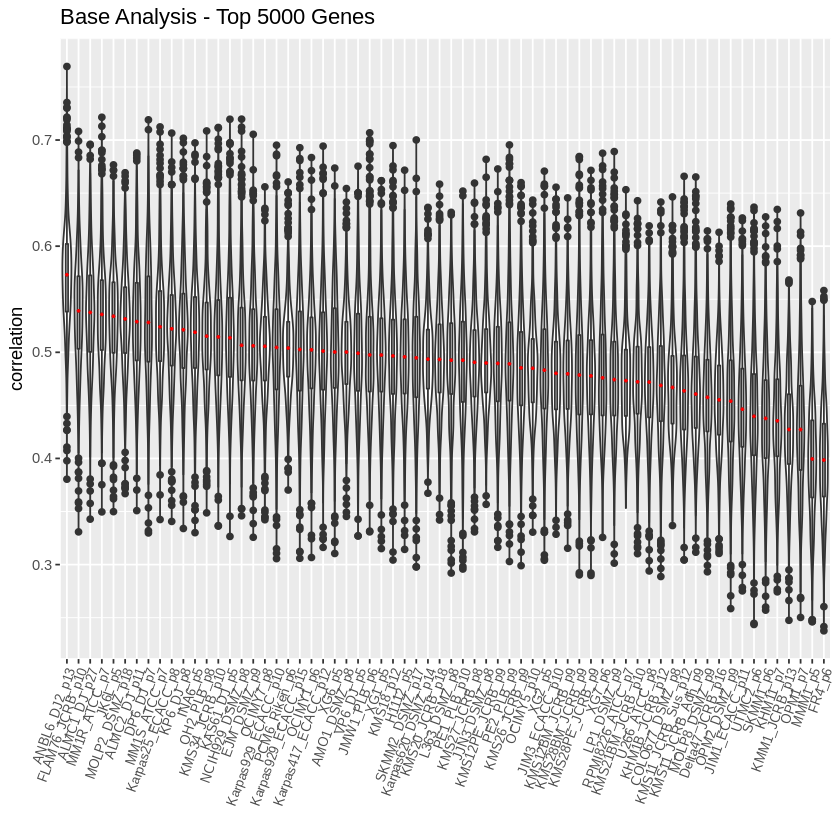

In [40]:
makeplots(norm_combined_5000, colnames(MM_patients), 'Base Analysis - Top 5000 Genes')

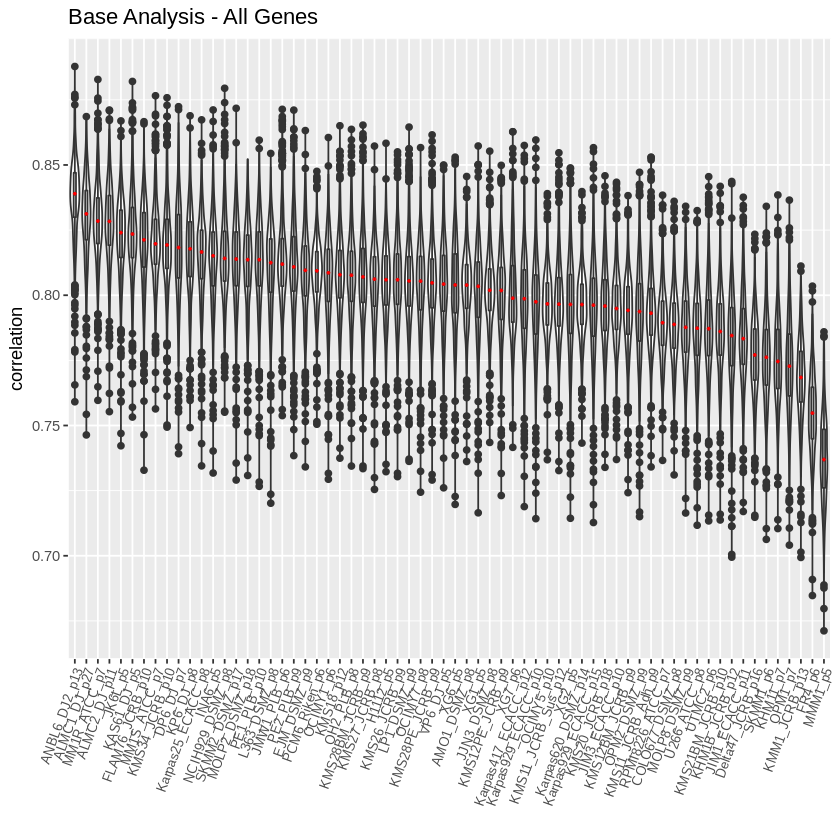

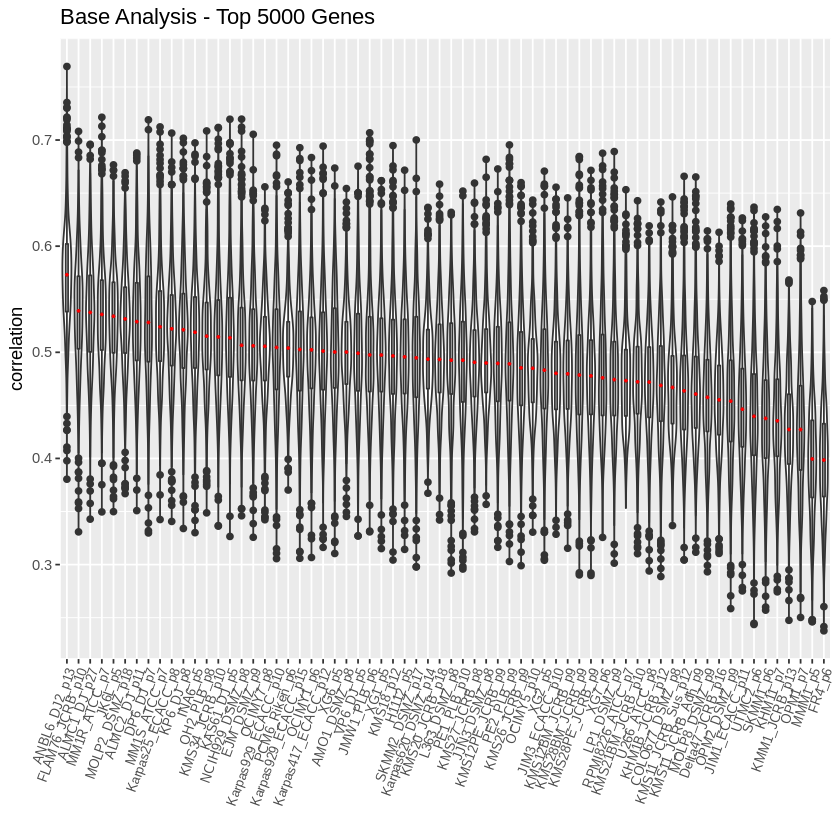

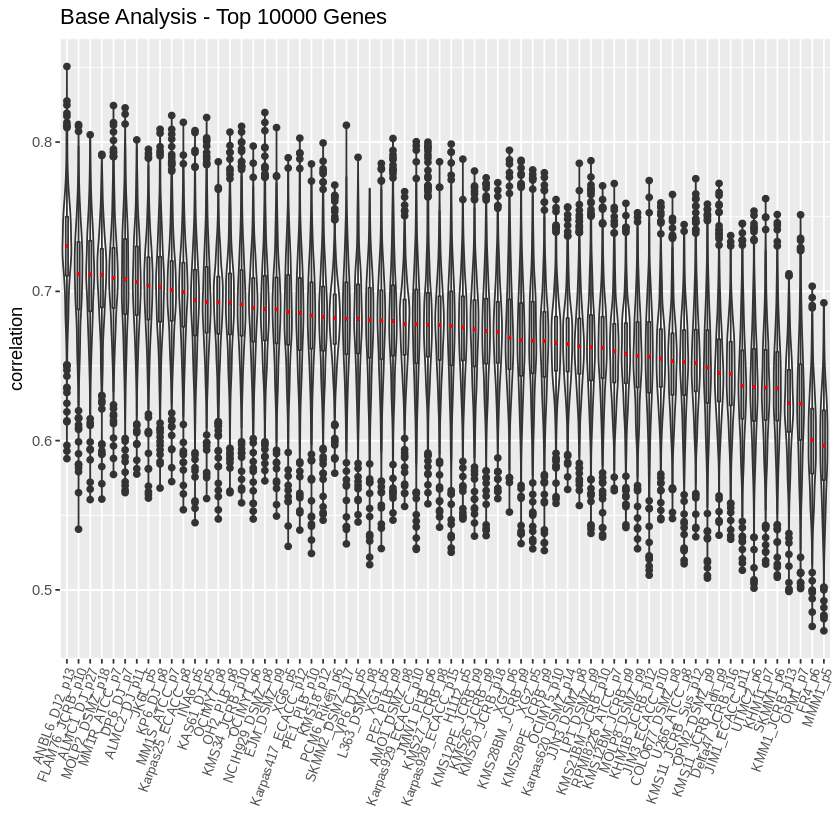

In [17]:
# plots for main analysis using all genes

makeplots(norm_combined, colnames(MM_patients), 'Base Analysis - All Genes')

# subsetting top 5000 / 10000 genes

norm_combined_5000 = norm_combined[keepi5000, ]
norm_combined_10000 = norm_combined[keepi10000, ]

# plots for main analysis using top 5000 / 10000 genes

makeplots(norm_combined_5000, colnames(MM_patients), 'Base Analysis - Top 5000 Genes')
makeplots(norm_combined_10000, colnames(MM_patients), 'Base Analysis - Top 10000 Genes')

In [18]:
MM_combined_2.filtered = cbind(CCLE_cell_line_3, MM_patients)
head(MM_combined_2.filtered)

,AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,56,642,15,17,204,13,4,7,14,24,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000419,10884,7383,7458,5989,5646,9925,4271,5864,5662,7070,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,2572,1482,2286,2691,1948,1876,2182,2068,2849,2044,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3844,2741,5379,3464,2487,2782,2757,2402,5753,4794,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,3761,4,17,18,4547,13572,11348,42,2,9,⋯,3064,46,46,14,303,58,77,11,174,22
ENSG00000000971,51,54,18,1617,36,62,11,155,27,12,⋯,2566,27,13,5,28,30,18,1680,56,10


converting counts to integer mode


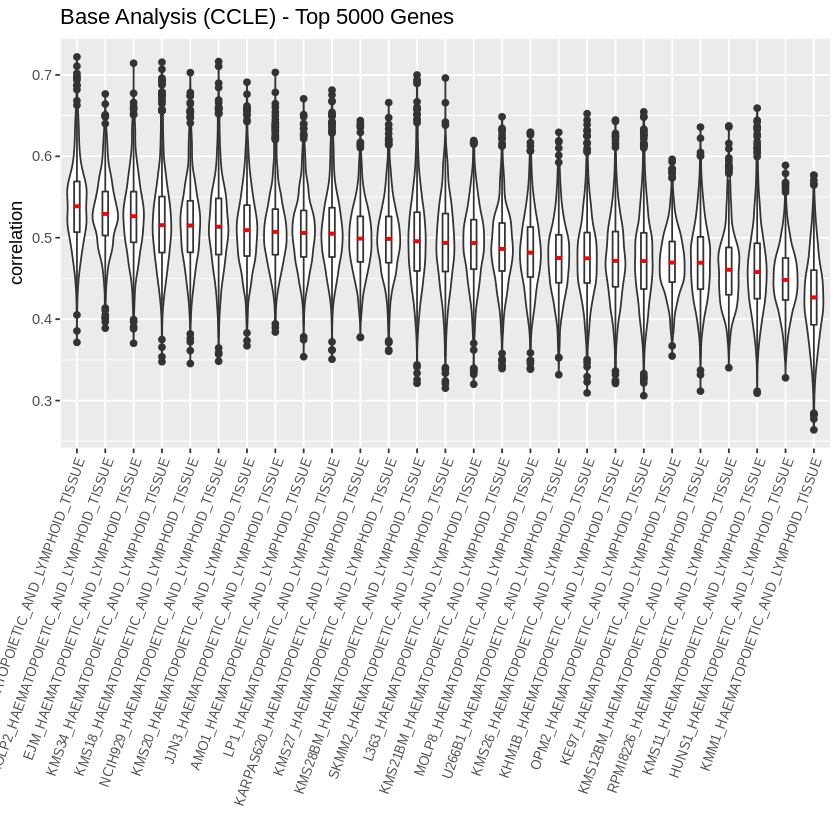

In [21]:
#MM_combined_2.filtered[is.nan(MM_combined_2.filtered)] = 0

MM_combined_2.filtered[is.na(MM_combined_2.filtered)] <- 0


norm_CCLE_combined = vst(as.matrix(MM_combined_2.filtered))
norm_CCLE_combined_5000 = norm_CCLE_combined[keepi5000, ]
# makeplots(norm_CCLE_combined_5000, colnames(MM_patients), 'Base Analysis (CCLE) - Top 5000 Genes')

MM.cor.v = cor(norm_CCLE_combined_5000, method = "s")
pnames = colnames(MM_patients)
clnames = colnames(CCLE_cell_line_3)
tumor_cell_all = data.frame()

for(patients in pnames){
    cell_line_tumor_cor = MM.cor.v[patients, clnames]
    cell_line_tumor_cor = data.frame(patient = patients, 
                                     sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
    tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
}

cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

  p <- ggplot(tumor_cell_all, aes(sample, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") + labs(title = 'Base Analysis (CCLE) - Top 5000 Genes') +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                       fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
        theme(panel.background = element_rect(color = 'white'), 
              axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
  )

In [38]:
print(cell_line_ordered)

 [1] MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     
 [2] MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
 [3] EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      
 [4] KMS34_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
 [5] KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
 [6] NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
 [7] KMS20_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
 [8] JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     
 [9] AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     
[10] LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE      
[11] KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
[12] KMS27_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
[13] KMS28BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
[14] SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
[15] L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     
[16] KMS21BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
[17] MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
[18] U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE   
[19] KMS26_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    
[20] KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    


In [36]:
M.cor.v.2 = cor(norm_combined_5000, method = "s")

In [35]:
head(MM.cor.v.2)

ERROR: Error in head(MM.cor.v.2): object 'MM.cor.v.2' not found


In [33]:
# M.cor.v.2 = cor(norm_combined_5000, method = "s")

pnames = colnames(MM_patients)
clnames = colnames(MM_cell_line)
tumor_cell_all = data.frame()

for(patients in pnames){
    cell_line_tumor_cor = MM.cor.v.2[patients, clnames]
    cell_line_tumor_cor = data.frame(patient = patients, 
                                     sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
    tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
}

cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

  p <- ggplot(tumor_cell_all, aes(sample, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") + labs(title = 'Base Analysis - Top 5000 Genes') +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                       fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
        theme(panel.background = element_rect(color = 'white'), 
              axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
        
        
)

(cell_line_ordered)

ERROR: Error in eval(expr, envir, enclos): object 'MM.cor.v.2' not found


In [ ]:
cell_line_ordered

In [22]:
colnames(CCLE_cell_line_3)

[1] "AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
 [2] "EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"      
 [3] "HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
 [4] "JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
 [5] "KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"
 [6] "KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
 [7] "KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
 [8] "KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
 [9] "KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[10] "KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"  
[11] "KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[12] "KMS20_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[13] "KMS21BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"  
[14] "KMS26_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[15] "KMS27_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[16] "KMS28BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"  
[17] "KMS34_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[18] "L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
[19] "LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"      
[20] "MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
[21] "MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[22] "MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[23] "NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"  
[24] "OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"     
[25] "RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE" 
[26] "SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"    
[27] "U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"